In [2]:
# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append("../../")

#spectrome modules
from spectrome.utils import functions, path
from spectrome.brain import Brain


from spectrome.forward import ntf_local_stimulus as nt_stim
from spectrome.forward import ntf_local as nt_nostim
from spectrome.forward import ntf_local_stimulus as nt_stim

from scipy.io import loadmat
from scipy import stats
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection

import pickle as pkl

In [4]:
##all the sessions data of EEG
data1=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess1.mat")
data2=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess2.mat")
data3=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess3.mat")
data4=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess4.mat")

In [5]:
##all the sessions mi 
sess1_mi_avg=data1['Avg_MI_EEG_DK']
sess2_mi_avg=data2['Avg_MI_EEG_DK']
sess3_mi_avg=data3['Avg_MI_EEG_DK']
sess4_mi_avg=data4['Avg_MI_EEG_DK']

In [6]:
##all the sessions resting state
sess1_rest_avg=data1['Avg_RS1_EEG_DK']
sess2_rest_avg=data2['Avg_RS1_EEG_DK']
sess3_rest_avg=data3['Avg_RS1_EEG_DK']
sess4_rest_avg=data4['Avg_RS1_EEG_DK']

In [7]:
##all the sessions baseline
sess1_base_avg=data1['Avg_Baseline_EEG_DK']
sess2_base_avg=data2['Avg_Baseline_EEG_DK']
sess3_base_avg=data3['Avg_Baseline_EEG_DK']
sess4_base_avg=data4['Avg_Baseline_EEG_DK']

In [8]:
scores = np.squeeze(loadmat("../../../Performance_Sess4.mat")['Performance_Sess4'])

In [9]:
df=pd.read_excel('../../../spectrome-bci/spectrome/ListROIs_DK.xlsx')

In [10]:
fvec=np.squeeze(data1["Freqs"])[3:30]

### FOOOF Fitting

#### for each region(roi) across performers

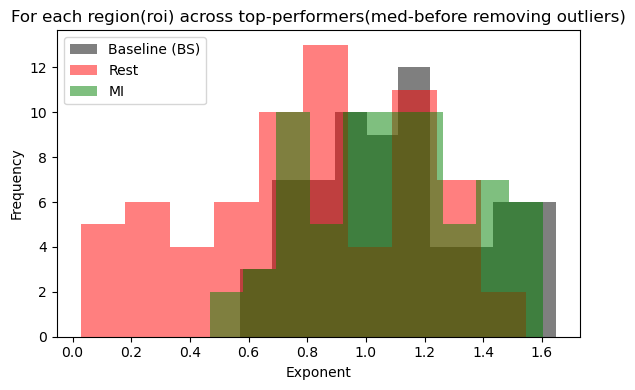

In [12]:
##For each  region across performers
reg_len =68
actual_spectra_rest=[]
actual_spectra_mi = []
actual_spectra_bs=[]
r2_rest=[]
r2_mi=[]
r2_base=[]
fit_rest=[]
fit_mi=[]
fit_base=[]

for i in range(reg_len):
    fm_rs = FOOOF(min_peak_height=0.05, verbose=False)
    spectra=np.median(sess4_rest_avg[:,i,3:30], axis=0)
    fm_rs.fit(fvec, spectra)
    r2_rest.append(round(fm_rs.r_squared_, 4))
    fit_rest.append(round(fm_rs.error_, 4))
    rs_slope = fm_rs.get_params('aperiodic_params', 'exponent')
    actual_spectra_rest.append(rs_slope)

for i in range(reg_len):
    fm_mi = FOOOF(min_peak_height=0.05, verbose=False)
    spectra=np.median(sess4_mi_avg[:,i, 3:30], axis=0)
    fm_mi.fit(fvec, spectra)
    r2_mi.append(round(fm_mi.r_squared_, 4))
    fit_mi.append(round(fm_mi.error_, 4))
    mi_slope = fm_mi.get_params('aperiodic_params', 'exponent')
    actual_spectra_mi.append(mi_slope)

for i in range(reg_len):
    fm_bs = FOOOF(min_peak_height=0.05, verbose=False) 
    spectra=np.median(sess4_base_avg[:,i, 3:30], axis=0)
    fm_bs.fit(fvec, spectra)
    r2_base.append(round(fm_bs.r_squared_, 4))
    fit_base.append(round(fm_bs.error_, 4))
    bs_slope = fm_bs.get_params('aperiodic_params', 'exponent')
    actual_spectra_bs.append(bs_slope)

plt.figure(figsize=(6,4))
plt.hist(actual_spectra_bs, alpha=0.5, label='Baseline (BS)', color='black')
plt.hist(actual_spectra_rest, alpha=0.5, label='Rest', color='r')
plt.hist(actual_spectra_mi, alpha=0.5, label='MI', color='green')
plt.xlabel('Exponent')
plt.ylabel('Frequency')
plt.title('For each region(roi) across top-performers(med-before removing outliers)')
plt.legend()

plt.tight_layout()
plt.show()

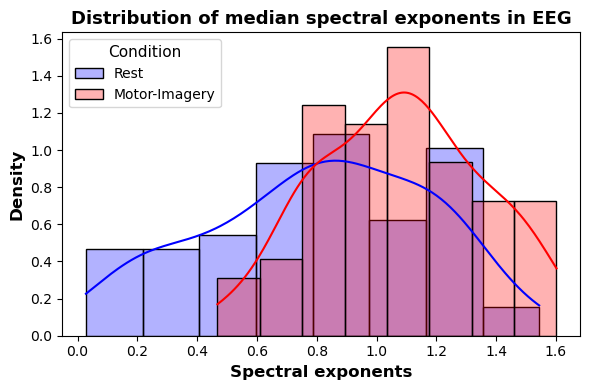

In [13]:
# sns.set_style("whitegrid")
plt.figure(figsize=(6, 4)) 

sns.histplot(actual_spectra_rest, label='Rest', color='blue', kde=True, stat='density', alpha=0.3, linewidth=1)
sns.histplot(actual_spectra_mi, label='Motor-Imagery', color='red', kde=True, stat='density', alpha=0.3, linewidth=1)

plt.xlabel('Spectral exponents', fontsize=12, fontweight='bold', color='black')
plt.ylabel('Density', fontsize=12, fontweight='bold',color='black')
plt.title('Distribution of median spectral exponents in EEG', fontsize=13, fontweight='bold')
plt.legend(title='Condition', fontsize=10, title_fontsize=11, frameon=True)

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
# ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')

plt.grid(False)
plt.tight_layout()
plt.show()


In [14]:
np.mean(actual_spectra_rest),np.mean(actual_spectra_mi)

(0.8045372648476706, 1.0761982468813092)

In [15]:
np.mean(r2_rest), np.mean(r2_mi)

(0.8590485294117647, 0.9735338235294118)

In [16]:
cnt=0
for num in r2_rest:
    if num<0.60:
        cnt+=1
print(cnt)

9


## individual spectra

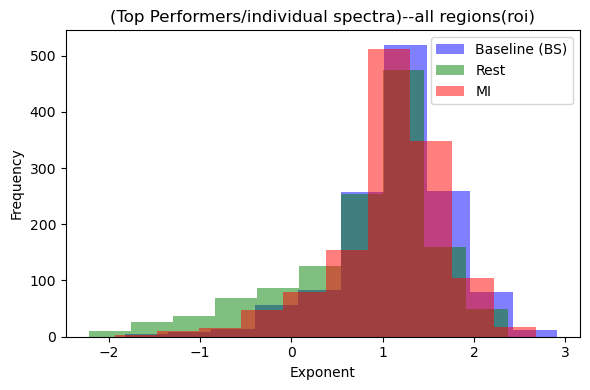

In [18]:
reg_len =68
sub_len=19
actual_spectra_rest_ind=[]
actual_spectra_base_ind=[]
actual_spectra_mi_ind=[]
r2_rest_ind=[]
r2_mi_ind=[]
r2_base_ind=[]
fit_rest_ind=[]
fit_mi_ind=[]
fit_base_ind=[]

##for each region--19 values
r2_rest_dict={i: [] for i in range(reg_len)}
r2_base_dict={i: [] for i in range(reg_len)}
r2_mi_dict={i: [] for i in range(reg_len)}

for i in range(reg_len):
    for j in range(sub_len):
        fm_rs=FOOOF(min_peak_height=0.05, verbose=False)
        spectra=sess4_rest_avg[j,i,3:30]
        fm_rs.fit(fvec, spectra)
        r2_rest_ind.append(round(fm_rs.r_squared_, 4))
        r2_rest_dict[i].append(round(fm_rs.r_squared_, 4))
        fit_rest_ind.append(round(fm_rs.error_, 4))
        rs_slope = fm_rs.get_params('aperiodic_params', 'exponent')
        actual_spectra_rest_ind.append(rs_slope)

for i in range(reg_len):
    for j in range(sub_len):
        fm_bs=FOOOF(min_peak_height=0.05, verbose=False)
        spectra=sess4_base_avg[j,i,3:30]
        fm_bs.fit(fvec,spectra)
        r2_base_ind.append(round(fm_bs.r_squared_, 4))
        r2_base_dict[i].append(round(fm_bs.r_squared_, 4))
        fit_base_ind.append(round(fm_bs.error_, 4))
        bs_slope = fm_bs.get_params('aperiodic_params', 'exponent')
        actual_spectra_base_ind.append(bs_slope)

for i in range(reg_len):
    for j in range(sub_len):
        fm_mi=FOOOF(min_peak_height=0.05, verbose=False)
        spectra=sess4_mi_avg[j,i,3:30]
        fm_mi.fit(fvec, spectra)
        r2_mi_ind.append(round(fm_mi.r_squared_, 4))
        r2_mi_dict[i].append(round(fm_mi.r_squared_, 4))
        fit_mi_ind.append(round(fm_mi.error_, 4))
        mi_slope = fm_mi.get_params('aperiodic_params', 'exponent')
        actual_spectra_mi_ind.append(mi_slope)

plt.figure(figsize=(6,4))
plt.hist(actual_spectra_base_ind, alpha=0.5, label='Baseline (BS)', color='b')
plt.hist(actual_spectra_rest_ind, alpha=0.5, label='Rest', color='g')
plt.hist(actual_spectra_mi_ind, alpha=0.5, label='MI', color='r')
plt.xlabel('Exponent')
plt.ylabel('Frequency')
plt.title('(Top Performers/individual spectra)--all regions(roi)')
plt.legend()

plt.tight_layout()
plt.show()

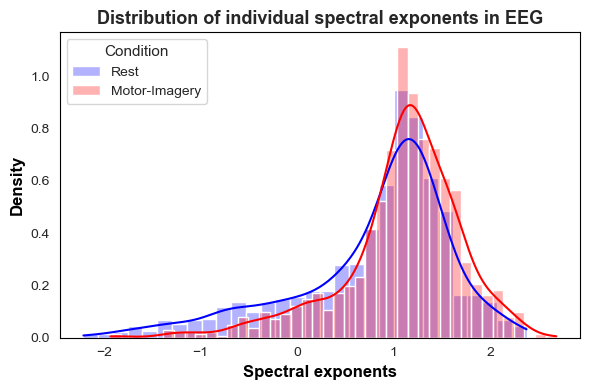

In [19]:
# plt.figure(figsize=(6, 4))

# # sns.histplot(actual_spectra_base_ind, label='Baseline (BS)', color='b', kde=True, stat='count', alpha=0.2)
# sns.histplot(actual_spectra_rest_ind, label='Rest', color='b', kde=True, stat='count', alpha=0.2)
# sns.histplot(actual_spectra_mi_ind, label='Motor-Imagery', color='r', kde=True, stat='count', alpha=0.2)

# plt.xlabel('Exponents')
# plt.ylabel('Count')
# plt.title('Exponents distribution for Individual spectra (EEG)')
# plt.legend()

# plt.tight_layout()
# plt.show()

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4)) 

sns.histplot(actual_spectra_rest_ind, label='Rest', color='blue', kde=True, stat='density', alpha=0.3, linewidth=1)
sns.histplot(actual_spectra_mi_ind, label='Motor-Imagery', color='red', kde=True, stat='density', alpha=0.3, linewidth=1)

plt.xlabel('Spectral exponents', fontsize=12, fontweight='bold', color='black')
plt.ylabel('Density', fontsize=12, fontweight='bold', color='black')
plt.title('Distribution of individual spectral exponents in EEG', fontsize=13, fontweight='bold')
plt.legend(title='Condition', fontsize=10, title_fontsize=11, frameon=True, loc='upper left')

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
# ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')

plt.grid(False)
plt.tight_layout()
plt.show()


In [20]:
np.mean(r2_rest_ind),np.mean(r2_mi_ind)

(0.8654517801857585, 0.9118633900928793)

In [21]:
np.mean(actual_spectra_rest_ind), np.mean(actual_spectra_mi_ind)

(0.7947231220454153, 1.0817036000455458)

In [22]:
ind_reg_avg_rest=[]

for i in range(68):
    ind_reg_avg_rest.append(np.mean(r2_rest_dict[i]))


In [23]:
np.mean(ind_reg_avg_rest)

0.8654517801857583